# Сегментирование клиентов банка

Проект посвящен сегментированию пользователей банка. Сегментация покажет, как клиенты пользуются услугами банка "Метанпромбанк".

Заказчик - менеджер продукта, который разрабатывает меры по удержанию клиентов и мероприятия для работы с целевой аудиторией. Пользователем результата по проекту будет менеджер продукта. Цель - определить, на какие основные сегменты делятся клиенты банка и выявить характеристики каждого сегмента.

# Шаг 1. Загрузка и предоработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth

import warnings
warnings.filterwarnings('ignore')

In [2]:
# чтение файла с данными и сохранение в df
try:
    df = pd.read_csv('bank_dataset.csv')
except:
    df = pd.read_csv('/datasets/bank_dataset.csv')
    

In [3]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#Отобразим всю необходимую информацию о файле
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Описание датасета

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

**Что стоит скорректировать:**
- названия столбцов к нижнему, "змеиному" регистру;
- пропуски и наличие дубликатов;
- столбцы `Gender`, `City` привести к бинарному виду;
- Привести данные к нужному типу

**В названиях столбцов cтрочные буквы сочетаются с прописными**

In [40]:
# приведение названий столбцов к нижним регистрам в таблице
df.columns = [x.lower() for x in df.columns]
df =  df.rename(columns={'userid':'user_id', 'creditcard':'credit_card'})
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

**Пропуски и наличие дубликатов**

In [41]:
# проверка на наличие явных дубликатов
print(f"Количество дубликатов: {df.duplicated().sum()}")
# проверка на наличие неявных дубликатов
print(f"Количество неявных дубликатов: {df['user_id'].duplicated().sum()}")
# подсчет пропущенных значений
print('Количество пропущенных значений:')
df.isnull().sum()

Количество дубликатов: 0
Количество неявных дубликатов: 0
Количество пропущенных значений:


user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Явные и неявные дубликаты отсутствуют. В колонке `balance` отсутствует 36 % данных. Рассмотрим с чем могут быть связанны пропуски в `balance`.

In [42]:
df[df['balance'].isna()]

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15648358,841,Рыбинск,М,28,4,NaN,2,1,1,179436.60,0
9992,15699841,726,Рыбинск,М,36,2,NaN,1,1,0,195192.40,0
9994,15762030,800,Ярославль,Ж,29,2,NaN,2,0,0,167773.55,0
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0


In [43]:
df_null=df[df['balance'].isna()].groupby('city').agg({'city': 'count'})
df_null=df_null.rename(columns = {'city':'count'})
df_null = df_null.reset_index()
df_null = df_null.sort_values(by='count', ascending=False)
df_null

,city,count
1,Ярославль,2418
0,Рыбинск,1199


In [44]:
df_churn = df[df['balance'].isna()].groupby('churn').agg({'churn': 'count'})
df_churn = df_churn.rename(columns = {'churn':'count'})
df_churn = df_churn.reset_index()
df_churn = df_churn.sort_values(by='churn', ascending=False)
df_churn

,churn,count
1,1,500
0,0,3117


In [45]:
df[df['balance'].isna()].describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,3.617000e+03,3617.000000,3617.000000,3617.000000,0.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,1.573469e+07,649.452861,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236
std,7.194749e+04,96.158798,10.492002,2.860781,NaN,0.496455,0.450704,0.499751,57730.828955,0.345195
min,1.560844e+07,350.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,90.070000,0.000000
25%,1.567226e+07,583.000000,31.000000,3.000000,NaN,1.000000,0.000000,0.000000,49506.820000,0.000000
50%,1.573608e+07,651.000000,37.000000,5.000000,NaN,2.000000,1.000000,1.000000,98618.790000,0.000000
75%,1.579629e+07,717.000000,43.000000,7.000000,NaN,2.000000,1.000000,1.000000,148330.970000,0.000000
max,1.585810e+07,850.000000,88.000000,10.000000,NaN,4.000000,1.000000,1.000000,199992.480000,1.000000


Среди городов в которых отсутствует `balance` присутствует Рыбинск и Ярославль. При оттоке клиентов данный показатель не является главным. Это может быть дебетовая карта или счет. Например, если человек в банке завел только кредитную карту.

In [46]:
df['balance'] = df['balance'].fillna(0)

**Для удобства обработки данных добавим бинарные столбцы**

In [47]:
#Создадим столбец, где в зависимости от возраста клиента, укажем принадлежность к возрастной группе
# молодые
df.loc[df['age'].between(18,30), 'age_group'] = 0
# взрослые_1
df.loc[df['age'].between(31,45), 'age_group'] = 1
#взрослые_2
df.loc[df['age'].between(46,60), 'age_group'] = 2
# пожилые
df.loc[df['age']>60, 'age_group'] = 3
# изменим тип данных
df['age_group']=df['age_group'].astype('int8')
df.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,age_group
0,15677338,619,Ярославль,Ж,42,2,0.00,1,1,1,101348.88,1,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,1
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,1
3,15744090,699,Ярославль,Ж,39,1,0.00,2,0,0,93826.63,0,1
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,1


In [72]:
# Для стобца "city" и "gender" сделаем разбивку
#df1 = pd.get_dummies(df, columns=["gender","city","products"])
df1 =  df1.rename(columns={'city_Ростов Великий':'city_Ростов_Великий'})
#Отобразим всю необходимую информацию о файле
df1.info()
df1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              10000 non-null  int64  
 1   score                10000 non-null  int64  
 2   age                  10000 non-null  int64  
 3   objects              10000 non-null  int64  
 4   balance              10000 non-null  float64
 5   credit_card          10000 non-null  int64  
 6   loyalty              10000 non-null  int64  
 7   estimated_salary     10000 non-null  float64
 8   churn                10000 non-null  int64  
 9   age_group            10000 non-null  int8   
 10  gender_Ж             10000 non-null  uint8  
 11  gender_М             10000 non-null  uint8  
 12  city_Ростов_Великий  10000 non-null  uint8  
 13  city_Рыбинск         10000 non-null  uint8  
 14  city_Ярославль       10000 non-null  uint8  
 15  products_1           10000 non-null  

,user_id,score,age,objects,balance,credit_card,loyalty,estimated_salary,churn,age_group,gender_Ж,gender_М,city_Ростов_Великий,city_Рыбинск,city_Ярославль,products_1,products_2,products_3,products_4,cluster_km
0,15677338,619,42,2,0.00,1,1,101348.88,1,1,1,0,0,0,1,1,0,0,0,0
1,15690047,608,41,1,83807.86,0,1,112542.58,0,1,1,0,0,1,0,1,0,0,0,0


**Вывод:**
- наименования столбцов приведены к нижнему регистру;
- дубликаты отсутствуют;
- обнаружено 3617 пропусков в столбце `balance`, из них 3117 у оставшихся клиентов, 500 у ушедших. Также пустые балансы присутствуют только у Рыбинска и Ярославля.
- добавили новые категориальные столбцы, которые в дальнейшем облегчат анализ данных

## Шаг 2.Исследовательский анализ данных (EDA)

**Распределие признаков**
    
Определим особенности данныхи, при необходимости построим графики по колонкам датасета

In [49]:
# score — баллы кредитного скоринга
print(df['score'].max())
print(df['score'].min())
df_score=df['score'].value_counts(normalize = True)
df_score = pd.DataFrame(df_score)
df_score.head(10)

850
350


,score
850,0.0233
678,0.0063
655,0.0054
667,0.0053
705,0.0053
684,0.0052
651,0.0050
670,0.0050
683,0.0048
648,0.0048


Максимальное количество баллов 850 и минимальное 350. Большой разброс по данным. у 2% клиентов высокий балл кредитного скоринга

In [50]:
# gender — пол;
df_gender_w = df1['gender_Ж'].value_counts(normalize = True)
print(df_gender_w*100)

df_gender_m = df1['gender_М'].value_counts(normalize = True)
print(df_gender_m*100)

0    54.57
1    45.43
Name: gender_Ж, dtype: float64
1    54.57
0    45.43
Name: gender_М, dtype: float64


- мужчин 55%; 
- женщин 45%.

In [51]:
# group_age- возрастные группы 
df_group = df['age_group'].value_counts(normalize = True)
df_group = pd.DataFrame(df_group*100)
df_group

,age_group
1,59.21
0,19.68
2,16.47
3,4.64


80 % - люди в возрасте до 45 лет, из которых 20 % - до 30 лет 

In [52]:
# objects — количество объектов в собственности,
df_objects = df['objects'].value_counts(normalize = True)
df_objects = pd.DataFrame(df_objects*100)
df_objects

,objects
2,10.48
1,10.35
7,10.28
8,10.25
5,10.12
3,10.09
4,9.89
9,9.84
6,9.67
10,4.90


Данные равномерно распределены. Большенство имеет более одного объекта в собственности

In [53]:
#products — количество продуктов, которыми пользуется клиент,
df_products = df['products'].value_counts(normalize = True)
df_products = pd.DataFrame(df_products*100)
df_products

,products
1,50.84
2,45.90
3,2.66
4,0.60


Очень малый процент людей использует более 2 продуктов 

In [54]:
#CreditCard — есть ли кредитная карта,
df_creditcard = df['credit_card'].value_counts(normalize = True)
df_creditcard  = pd.DataFrame(df_creditcard *100)
df_creditcard 

,credit_card
1,70.55
0,29.45


In [55]:
#Loyalty — активный клиент,
df_loyalty = df['loyalty'].value_counts(normalize = True)
df_loyalty = pd.DataFrame(df_loyalty *100)
df_loyalty

,loyalty
1,51.51
0,48.49


Почти 49% пользователей банка не лояльны к нему. Далее нужно рассмотреть это в зависимости от возраста. Это позволит нам сузит проблему

In [56]:
# describe() для всех столбцов
df1.describe()

,user_id,score,age,objects,balance,credit_card,loyalty,estimated_salary,churn,age_group,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль,products_1,products_2,products_3,products_4
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,76485.889288,0.70550,0.515100,100090.239881,0.203700,1.060700,0.454300,0.545700,0.250900,0.247700,0.501400,0.508400,0.459000,0.026600,0.006000
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.45584,0.499797,57510.492818,0.402769,0.737204,0.497932,0.497932,0.433553,0.431698,0.500023,0.499954,0.498341,0.160919,0.077231
min,1.560844e+07,350.000000,18.000000,0.000000,0.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,0.000000,0.00000,0.000000,51002.110000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,97198.540000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,127644.240000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,1.00000,1.000000,199992.480000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Портрет среднестатистического клиента:**
- Не старше 37 лет;
- В наличии не более 2 объектов;
- Использует не более 2 продуктов банка;
- Средняя зарплата около 100 тысяч;
- Наличие кредитной карты;
- Почти 50% пользователей из Ярославля, остальные в равных долях в Ростов Великий и Рыбинске.

**Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался**

In [57]:
churn_group = df1.groupby(['churn']).mean()
churn_group

,user_id,score,age,objects,balance,credit_card,loyalty,estimated_salary,age_group,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль,products_1,products_2,products_3,products_4
churn,,,,,,,,,,,,,,,,,,
0,1.573390e+07,651.853196,37.408389,5.033279,72745.296779,0.707146,0.554565,99738.391772,0.960191,0.427477,0.572523,0.212859,0.259199,0.527942,0.461509,0.532714,0.005777,0.000000
1,1.573279e+07,645.351497,44.837997,4.932744,91108.539337,0.699067,0.360825,101465.677531,1.453608,0.559156,0.440844,0.399607,0.202749,0.397644,0.691703,0.170839,0.108002,0.029455


**Вывод по средним значениям по оттоку:**
- Баллы кредитного скоринга не имеют значительных различий между группами;
- Средний возраст различается: 37 лет у оставшегося клиента и 44 у ушедшего;
- Таким образом люди с оттоком попадают чаще в группу 1 (возраст от 31 до 45 лет);
- среднее количество по имеющимся объектам недвижимости почти одинаковое;
- люди, которые используют 1 продукт подвержену к оттоку;
- баланс на счетах - почти одинаковый;
- лояльность  выше у оставшихся;
- в Ростове Великом и Ярославле отток больше чем в Рыбинске (отток незначительно меньше оставшихся);
- Женщины чаще уходят;

**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**

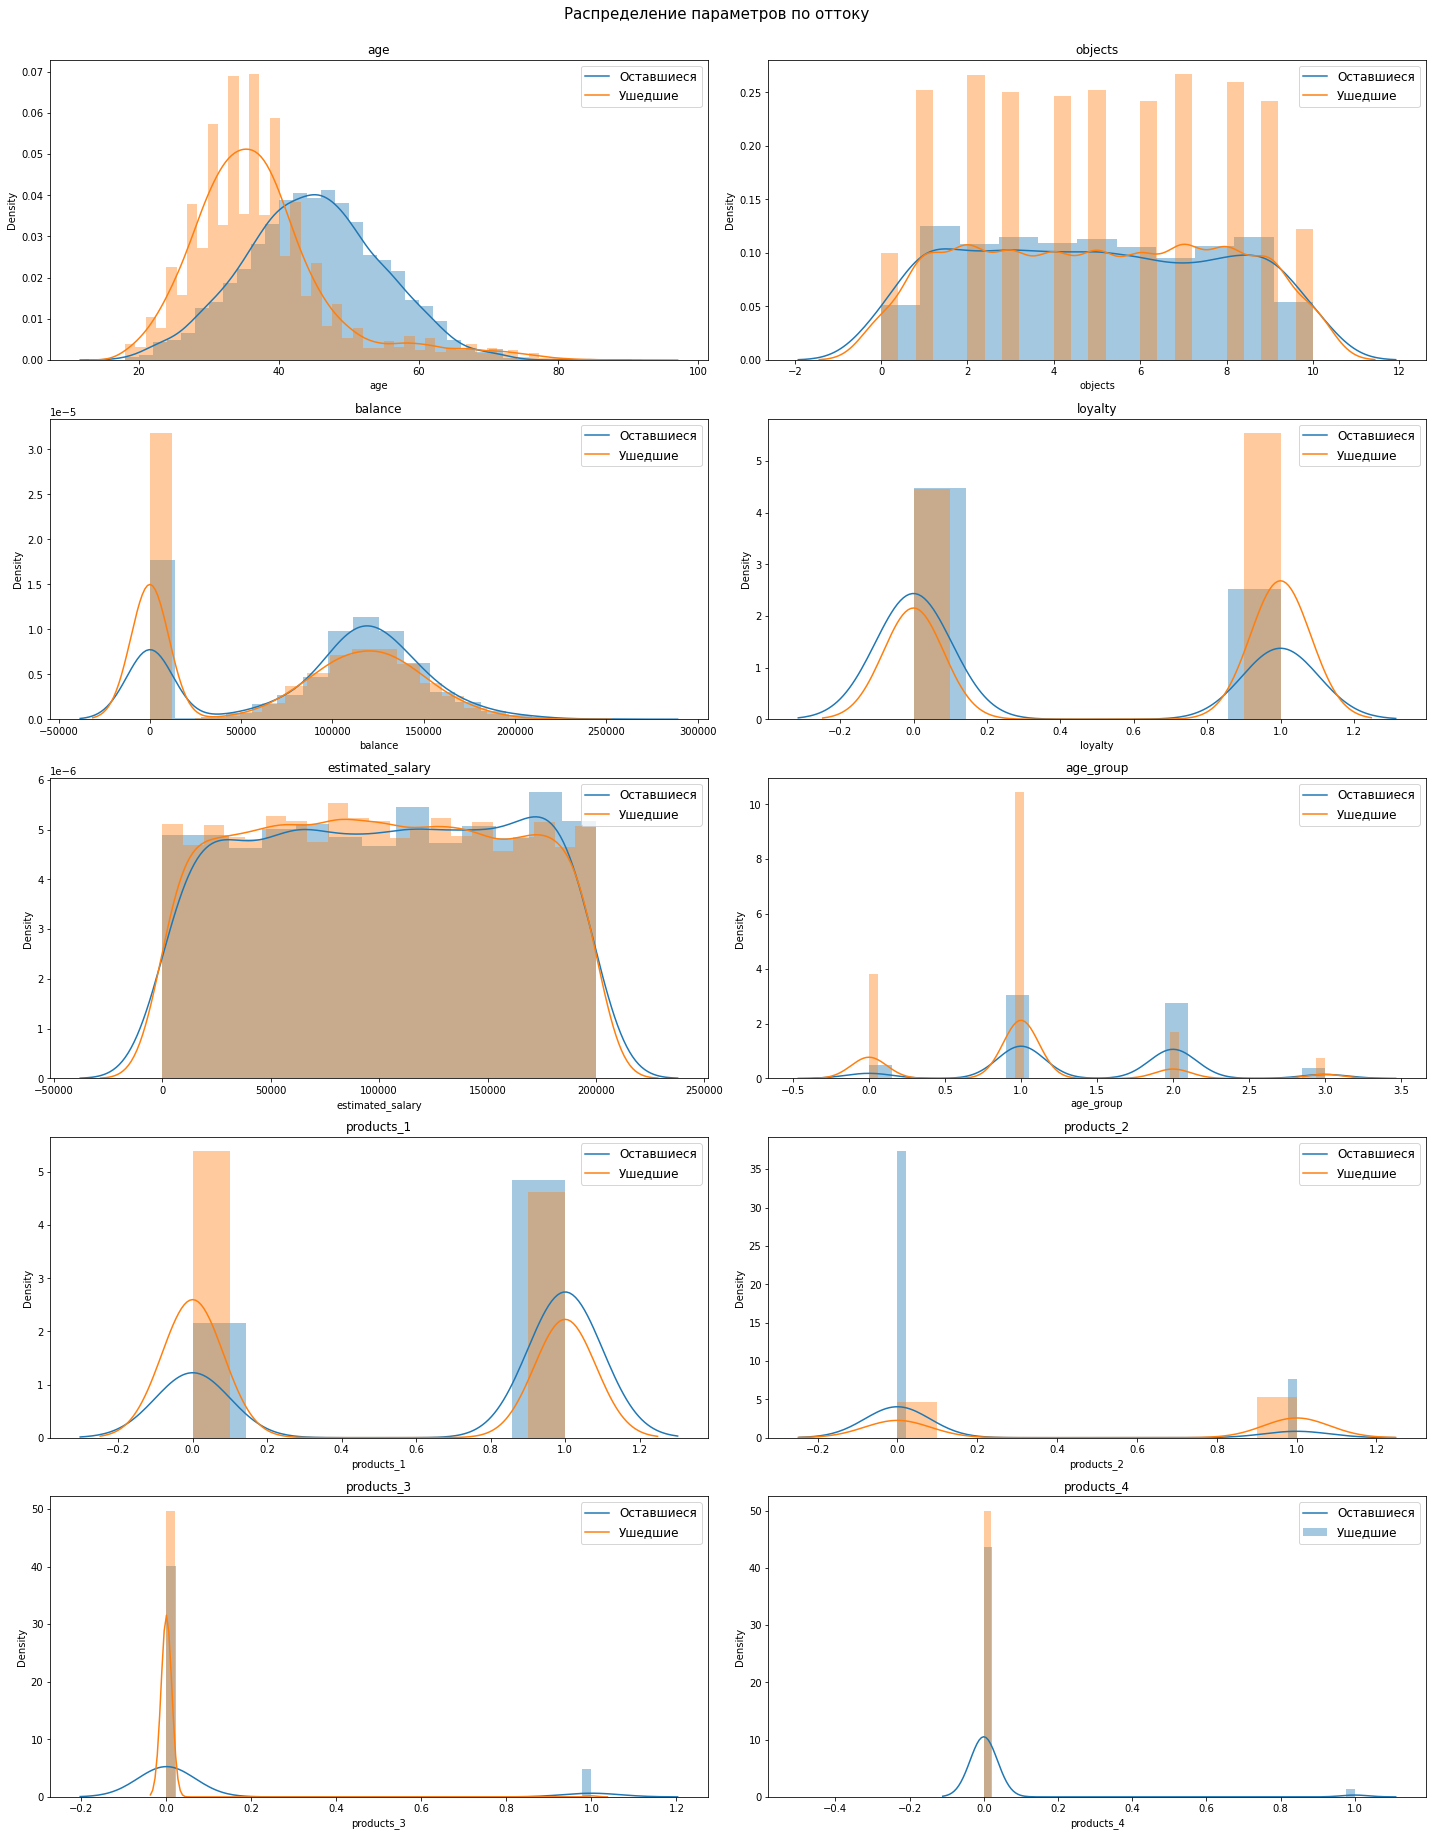

In [58]:
research = ['age', 'objects', 'balance', 'loyalty', 'estimated_salary','age_group',
            'products_1', 'products_2','products_3', 'products_4']

# число рядов и столбцов в сетке графиков
col_count, row_count = 2, 6
# размер графиков
plt.figure(figsize = (20, 30))

# положение графиков в сетке, i+1 порядковый номер графика
for i, j in enumerate(research):
    for churn in df1['churn'].unique():
        current = df1.query('churn == @churn')
        sns.distplot(current[j], ax = plt.subplot(row_count, col_count, i+1))
    
    # подзаголовки на каждый график
    plt.title(j)
    
    # легенды на каждый график
    plt.legend(labels=['Оставшиеся', 'Ушедшие'], fontsize = 12)

# название
plt.suptitle('Распределение параметров по оттоку', y = 1, fontsize = 15)
# настройка подзаголовков
plt.tight_layout()
plt.show()

*Графики, которые не имеют существенных различий:* 
- кредитный скоринг, 
- количество объектов, 
- зарплата, 
- наличие кредитной карты.

Данные признаки не оказывают существенного влияния на отток клиентов

*Явные различия в поведении клиентов по признакам:*
- возраст и возрастные группы, 
- баланс счета,
- количество используемых продуктов.

**Построим матрицу корреляций и отобразим её.**

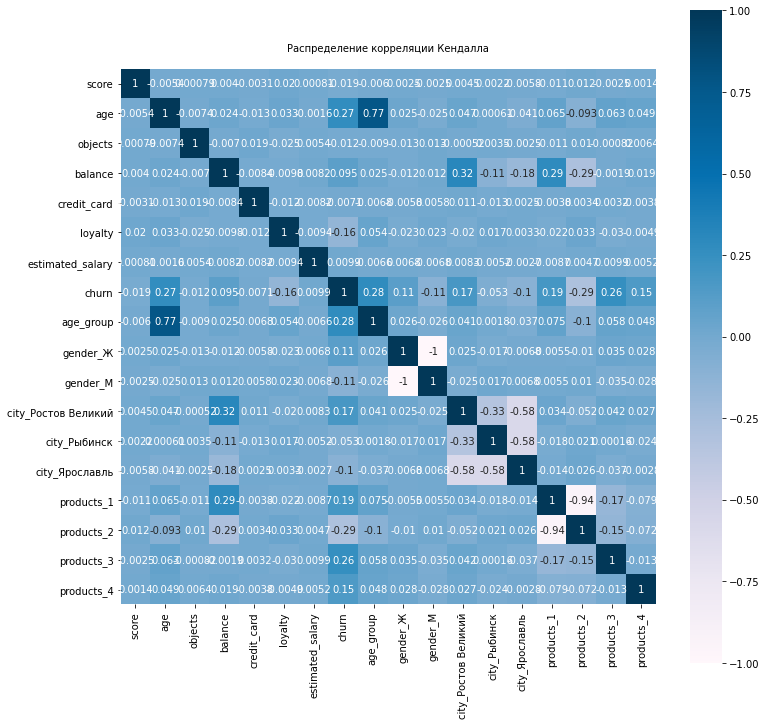

,score,age,objects,balance,credit_card,loyalty,estimated_salary,churn,age_group,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль,products_1,products_2,products_3,products_4
score,1.000000,-0.005414,0.000791,0.004034,-0.003110,0.019844,0.000807,-0.019049,-0.006044,0.002463,-0.002463,0.004466,0.002205,-0.005776,-0.011068,0.011691,-0.002468,0.001353
age,-0.005414,1.000000,-0.007424,0.023611,-0.012666,0.033027,-0.001571,0.268573,0.774648,0.024692,-0.024692,0.046619,0.000612,-0.040950,0.065166,-0.093340,0.063294,0.048555
objects,0.000791,-0.007424,1.000000,-0.007016,0.019107,-0.024508,0.005423,-0.011947,-0.009021,-0.012903,0.012903,-0.000522,0.003473,-0.002546,-0.011176,0.010487,-0.000818,0.006381
balance,0.004034,0.023611,-0.007016,1.000000,-0.008407,-0.009828,0.008200,0.094983,0.025392,-0.011544,0.011544,0.317787,-0.108453,-0.181908,0.285114,-0.288309,-0.001855,0.018525
credit_card,-0.003110,-0.012666,0.019107,-0.008407,1.000000,-0.011866,-0.008199,-0.007138,-0.006835,-0.005766,0.005766,0.010577,-0.013480,0.002467,-0.003845,0.003414,0.003186,-0.003778


In [59]:
from scipy.stats import kendalltau
# матрица корреляций
df_corr = df1.drop(['user_id'], axis=1)
m_corr = df_corr.corr(method='kendall')
plt.figure(figsize = (12, 12))

# тепловая карта с подписями для матрицы корреляций
sns.heatmap(m_corr, annot=True, square=True, cmap= 'PuBu')
plt.title('Распределение корреляции Кендалла\n', fontsize=10)
plt.show()

m_corr.head()

**Выводы на основании корреляции:**
- высокая корреляция наблюдается между параметрами возраст клиента и факт его оттока;
- клиенты из Ростова Великого имеют с большей вероятностью средства на балансе, чем жители из других представленных городов. 
- для жителей Ростова Великого, характерен больший отток из банка 
- также для жителей Ростова более характерен отток из банка
- взаимосвязь с клиентами банка женского пола и оттоком 
- количество продуктов влияет на отток: 1 или 3 продукта

**Вывод по EDA:**

*1. Портрет среднестатистического клиента:*
- Не старше 37 лет;
- В наличии не более 2 объектов;
- Использует не более 2 продуктов банка;
- Средняя зарплата около 100 тысяч;
- Наличие кредитной карты;
- Почти 50% пользователей из Ярославля, остальные в равных долях в Ростов Великий и Рыбинске.

*2. Оценка результата после детального анализа данных:*
- Баллы кредитного скоринга не имеют значительных различий между группами;
- Средний возраст различается: 37 лет у оставшегося клиента и 44 у ушедшего;
- Таким образом люди с оттоком попадают чаще в группу 1 (возраст от 31 до 45 лет);
- среднее количество по имеющимся объектам недвижимости почти одинаковое;
- люди, которые используют 1 продукт подвержену к оттоку;
- баланс на счетах - почти одинаковый;
- лояльность  выше у оставшихся;
- в Ростове Великом и Ярославле отток больше чем в Рыбинске (отток незначительно меньше оставшихся);
- Женщины чаще уходят;

# Шаг 3. Выявление портреты клиентов, которые склонных уходить из банка

**Стандартизируем данные**

In [60]:
# создаём объект класса scaler (нормализатор)
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
df_scaler = scaler.fit_transform(df1.drop(columns = ['churn'])) 

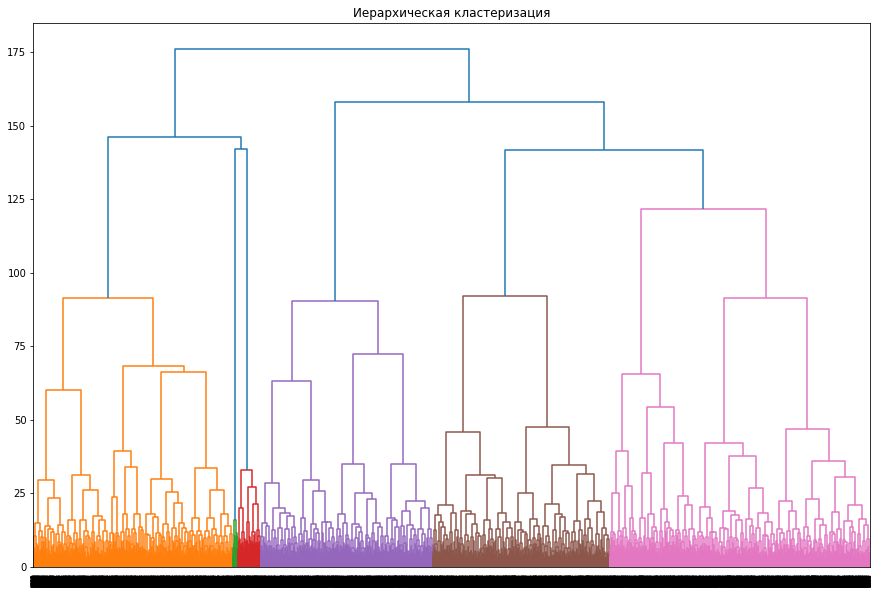

In [61]:
linked = linkage(df_scaler, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

**Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Число кластеров n=6**

In [62]:
from sklearn.cluster import KMeans
# число кластеров, равное 5, и фиксация значения random_state для воспроизводимости результата
km = KMeans(n_clusters=6, random_state=0) 
# применение алгоритма к данным и формирование вектора кластеров
labels = km.fit_predict(df_scaler) 
# сохранение меток кластера в поле датасета
df1['cluster_km'] = labels
# вывод статистики по средним значениям признаков по кластеру
clusters = df1.groupby(['cluster_km']).mean()
clusters

,user_id,score,age,objects,balance,credit_card,loyalty,estimated_salary,churn,age_group,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль,products_1,products_2,products_3,products_4
cluster_km,,,,,,,,,,,,,,,,,,,
0,1.573316e+07,649.707880,40.043970,4.958206,96809.186003,0.702656,0.494558,100461.898158,0.332172,1.142360,1.000000,0.000000,0.289073,0.224641,0.486286,0.999565,0.000000,0.000435,0.0
1,1.573508e+07,651.753692,37.943296,5.007679,33502.688145,0.700532,0.511518,100996.890910,0.128175,0.986415,1.000000,0.000000,0.000000,0.335499,0.664501,0.000000,0.943887,0.056113,0.0
2,1.573069e+07,648.712660,39.033665,5.006164,93691.280526,0.704125,0.518255,99110.471427,0.183973,1.071124,0.000000,1.000000,0.000000,0.335230,0.664770,0.997155,0.000000,0.002845,0.0
3,1.573528e+07,652.273403,37.732046,5.097078,31871.784567,0.705300,0.534423,99956.712100,0.064884,0.987122,0.000000,1.000000,0.000000,0.335810,0.664190,0.000000,0.966815,0.033185,0.0
4,1.571936e+07,653.583333,45.683333,5.300000,93733.135000,0.683333,0.483333,104763.723333,1.000000,1.483333,0.633333,0.366667,0.400000,0.116667,0.483333,0.000000,0.000000,0.000000,1.0
5,1.573517e+07,650.493963,39.382547,4.991218,119758.567415,0.716246,0.520307,99907.394654,0.262349,1.082327,0.282656,0.717344,0.999451,0.000549,0.000000,0.375960,0.570801,0.053238,0.0


Отметим, что среди женщин лояльность к банку более низкая. 

Для дальнейшего описания портрета клиентов, выберем те, где большой процент оттока. Для этого выведем статистику по кластерам. Оставим 3 группы для описание портрета 

In [63]:
# выводим статистику наших признаков по кластеру
df_churn = df1.groupby('cluster_km')['churn'].sum().reset_index()
#расчитываем долю
total = df_churn['churn'].sum()
df_churn['%'] = (df_churn['churn'] / total * 100).round(2)
display(df_churn)

,cluster_km,churn,%
0,0,763,37.46
1,1,217,10.65
2,2,388,19.05
3,3,131,6.43
4,4,60,2.95
5,5,478,23.47


*1. Портреты клиенов, которые уходят из банка:*

`churn`=0.2 в группе 2:
- мужчина в возрасте 39 лет из Ярославля;
- пользуется 1 продуктом;
- в среднем 5 объектов в собственности; 
- Не лояльны.

`churn`=0.33 в группе 0:
- женщина старше 40, из Ярославля;
- пользуется 1 продуктом; 
- в среднем 5 объектов в собственности;
- на половину лояльны к банку;

`churn`=0.26 в группе 5:
- мужчина возраста 39, из Ростов Великий;
- пользуется 2 или 3 продуктами;
- в среднем 5 объектов в собственности;
- Не лояльны.

Рассмотрим выборку данных для каждого сигмента. Процент оттока и количество 

In [112]:
df_group_2=df1.query('gender_М==1 and age>=39 and city_Ярославль==1 and objects >= 5 and products_1==1 and loyalty==0')['churn'].value_counts()
df_group_2 = pd.DataFrame(df_group_2)
df_group_2['%']= round((df_group_2['churn'] /df_group_2['churn'].sum())*100)
df_group_2

,churn,%
0,88,54.0
1,75,46.0


In [108]:
df_group_5 = df1.query('gender_М==1 and age>=39 and city_Ростов_Великий==1 and objects >= 5 and loyalty==0 and products_2==1 or products_3==1')['churn'].value_counts()
df_group_5 = pd.DataFrame(df_group_5)
df_group_5['%']= round((df_group_5['churn'] /df_group_5['churn'].sum())*100)
df_group_5

,churn,%
1,233,72.0
0,92,28.0


In [109]:
df_group_0=df1.query('gender_Ж==1 and age>=40 and city_Ярославль==1 and objects >= 5 and loyalty==0 and products_1==1')['churn'].value_counts()
df_group_0 = pd.DataFrame(df_group_0)
df_group_0['%']= round((df_group_0['churn'] /df_group_0['churn'].sum())*100)
df_group_0

,churn,%
1,78,57.0
0,59,43.0


**Выводы:** 
Общий отток из датасета 500 человек 386 определены и разбиты на сегменты. Это позволит нам составить максимально обширные рекомендации, которые покроют большую часть оттока людей. У данных сегментов есть общее: это люди все старше 39 лет и имеют более 5 объектов в собственности

# Шаг 4. Формулировка и проверка статистических гипотез

## 1.Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались.

Поскольку мы имеем дело со средними, то применим метод проверки гипотезы о равенстве двух средних

**Сформулируем гипотезы H0 и H1 для анализа долей:**

- Нулевая гипотеза H0 - "Нет оснований считать средние значения разными"

- Альтернативная гипотеза Н1 - "Между средними значениями есть значимая разница"

In [29]:
salary_churn_0 = df.query('churn == 0')['estimated_salary']
salary_churn_1= df.query('churn == 1')['estimated_salary']

In [30]:
#За критический уровень статистической значимости alpha примем значение 0,05
alpha = 0.05 

results = st.mannwhitneyu(salary_churn_1, salary_churn_0)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: есть различие в доходе между теми клиентами, которые ушли и теми, которые остались')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: нет различия в доходе между теми клиентами, которые ушли и теми, которые остались'
    )

p-значение:  0.22705150930153783
Не получилось отвергнуть нулевую гипотезу: нет различия в доходе между теми клиентами, которые ушли и теми, которые остались


**Не поличилось отвергнуть нулевую гипотезу**, а значит статистически значимых различий в уровне доходов между клиентами, ушедшими в отток, и клиентами, которые продолжают пользоваться услугами банка нет.



## 2. Проверка гипотезы различия количества продуктов  между теми клиентами, которые ушли и теми, которые остались.

Проверить, есть ли статистически значимое различие в количестве продуктов  между клиентами, ушедшими в отток, и клиентами, которые продолжают пользоваться услугами банка

**Сформулируем гипотезы H0 и H1 для анализа:**

- Нулевая гипотеза H0 - "Статистически значимых различий в распределении количества используемых продуктов банка между клиентами, ушедшими в отток, и клиентами, которые продолжают пользоваться услугами банка нет"


- Альтернативная гипотеза Н1 - "Статистически значимые различия в распределении количества используемых продуктов банка между клиентами, ушедшими в отток, и клиентами, которые продолжают пользоваться услугами банка есть."

In [31]:
prod_churn_0 = df.query('churn == 0')['products']
prod_churn_1= df.query('churn == 1')['products']

In [32]:
#За критический уровень статистической значимости alpha примем значение 0,05
alpha = 0.05
#Выполним тест Манна-Уитни
results_prod = st.mannwhitneyu(prod_churn_0, prod_churn_1)
print('p-значение:', results_prod.pvalue)

if results_prod.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу: есть различия ')

p-значение: 5.275105212817194e-36
Отвергаем нулевую гипотезу


**Не поличилось отвергнуть нулевую гипотезу**, а значит статистически значимых различий в количестве продуктов между клиентами, ушедшими в отток, и клиентами, которые продолжают пользоваться услугами банка нет.

# Шаг 5. Выводы и базовые рекомендации по работе с клиентами

В ходе исследовательского анализа данных  составлен портрет клиента:
- Не старше 37 лет;
- В наличии не более 2 объектов;
- Использует не более 2 продуктов банка;
- Средняя зарплата около 100 тысяч;
- Наличие кредитной карты;
- Почти 50% пользователей из Ярославля, остальные в равных долях в Ростов Великий и Рыбинске.

Оценка результата после детального анализа данных:
- Баллы кредитного скоринга не имеют значительных различий между группами;
- Средний возраст различается: 37 лет у оставшегося клиента и 44 у ушедшего;
- Таким образом люди с оттоком попадают чаще в группу 1 (возраст от 31 до 45 лет);
- среднее количество по имеющимся объектам недвижимости почти одинаковое;
- люди, которые используют 1 продукт подвержену к оттоку;
- баланс на счетах - почти одинаковый;
- лояльность  выше у оставшихся;
- в Ростове Великом и Ярославле отток больше чем в Рыбинске (отток незначительно меньше оставшихся);
- Женщины чаще уходят;

 Рекомендации на основании данных:
- У нас большой отток среди людей старше 40 лет, они еще не пенсионеры, но уже задумываются об этом. Стоит предложить накопительную программу сбережений для данной категории людей.
- среди женщин не высокая лояльность к банку. Стоить повысить клиентоориентированность персонала банка путем проведения семинаров по повышению уровня доброжелательности к клиентам;
- В Ростове большой отток, может появился конкурент. Провести анализ предоставляемых услуг нашего нового конкурента в Ростове, чтобы, после необходимого анализа предоставлять более выгодные предложения с нашей стороны для клиентов из этого города, а также и для других более крупных городов (Ярославль и Рыбинск)
- увеличивать привилегии для клиентов, которые пользуются большим количеством продуктов (увеличением процентов по вкладам, уменьшением стоимости годового обслуживания карты, уменьшением процентов по кредитам и пр.) В среднем челове использует 1-2 продукта, может другие продукты его не устраивают;

По результатам проверки двух гипотез, выяснилось, что на отток клиентов не влияет уровень дохода и количество продуктов. При равных этих двух параметров клиенты всеравно склонны к оттоку.





# Шаг 6. Создание презентации

[презентация](https://docs.google.com/presentation/d/1hU8m5gW4ePpSTKC_k58uQzFslweBlcdp-PaDloyphW4/edit?usp=sharing)